# ELEC-E7851 Computational User Interface Design

# Bandits (17.11.2020)
### Kashyap Todi (www.kashyaptodi.com)

In [5]:
import time
import random
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Defining a Bandit

We start by defining a Bandit.

A bandit has $n$ arms.<br/>
Each arm has a reward probability $\theta$.<br/>
When we pull an arm $i$, the bandit returns a reward with corresponding probability $i_\theta$.

In [6]:
class Bandit():
    def __init__(self, n, thetas):
        assert n == len(thetas)
        self.n = n # Number of arms
        self.thetas = thetas # Reward probabilities
        self.best_theta = max(self.thetas) # Reward probability of best arm
    
    def pull_arm(self, i):
        # Function to pull an arm i and return a reward (0 or 1) with probability theta for i
        return 1 if np.random.random() < self.thetas[i] else 0
        

Let's create a Bandit instance with 3 arms

In [7]:
bandit = Bandit(3, [0.3,0.4,0.5])

## Defining a Generic Solver

A generic Bandit solver consists of:
1. bandit: A Bandit object
2. counts: Number of times each arm has been pulled
3. actions: A History of actions taken (arms pulled)
4. regret: Cumulative regret until current time step
5. regrets: A history of cumulative regrets

A solver must specify the steps taken during a single time step (`run_one_step`)

A solver can be run $num\ steps$ times, to calculate the cumulative regret and optionally the estimated $\theta$s.



In [8]:
class Solver():
    def __init__(self, bandit):
        np.random.seed(int(time.time()))
        # bandit(Bandit): the target bandit to solve
        assert isinstance (bandit, Bandit)
        self.bandit = bandit
        self.counts = [0] * bandit.n # Number of times each arm pulled
        self.actions = [] # Action history
        self.regret = 0. # Cumulative regret
        self.regrets = [0.] # History of regrets
    
    def update_regret(self, i):
        # Update cumulative regret and regret history when arm i is pulled
        self.regret += self.bandit.best_theta - self.bandit.thetas[i]
        self.regrets.append(self.regret)
        
    @property
    def estimated_thetas(self):
        raise NotImplementedError
    
    # Generic function that performs one step, and returns index of arm pulled    
    def run_one_step(self):
        raise NotImplementedError
        
    # Conduct one trial with given number of iterations (steps)       
    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)   
            

## Defining an Experiment
Let us now define an experiment to run the solver for n trials with m iterations each trial.

In [9]:
def run_solver(solver, trials = 20, iterations = 1000):
    cumulative_regrets = [] # Cumulative regret for all 20 trials
    for trial in range(trials):
        solver.regret = 0.
        solver.regrets = [0.]
        solver.run(iterations)
        cumulative_regrets.append(solver.regret)
    print(f'Solver: {solver.name}\nCumulative regret (mean): {np.mean(cumulative_regrets)}; Cumulative regret (std): {np.std(cumulative_regrets)}')
    action_count = [solver.actions.count(arm)/trials for arm in range(bandit.n)]
    print(f"Actions per arm: {action_count}")
    

## Implement Solvers

### 1. Explore-Only:
First, let's write a random solver, that randomly explores at every iteration:

In [10]:
class Random(Solver):
    def __init__(self, bandit):
        super(Random, self).__init__(bandit)
        self.name = "Random"
        
        
    def run_one_step(self):
        i = np.random.randint(0, self.bandit.n) # Select random arm
        reward = self.bandit.pull_arm(i)
        return i

Let us now try running this Random solver with our 3-armed bandit

In [11]:
random_solver = Random(bandit)
run_solver(random_solver)

Solver: Random
Cumulative regret (mean): 100.3200000000001; Cumulative regret (std): 2.384239920813331
Actions per arm: [334.65, 333.9, 331.45]


### 2. Exploit-Only:
Next, let's write a Greedy solver, that exploits a pre-determined arm at every iteration:

In [12]:
class Greedy(Solver):
    def __init__(self, bandit, arm):
        super(Greedy, self).__init__(bandit)
        self.name = "Greedy"
        self.arm = arm
    
    def run_one_step(self):
        reward = self.bandit.pull_arm(self.arm)
        return self.arm
    

Let's try out the Greedy solver next

In [13]:
greedy_solver = Greedy(bandit, random.choice(range(bandit.n)))
run_solver(greedy_solver)

Solver: Greedy
Cumulative regret (mean): 199.99999999999721; Cumulative regret (std): 2.842170943040401e-14
Actions per arm: [1000.0, 0.0, 0.0]


 ### 3. $\epsilon$-Greedy:
 
We can explore random arms with a fixed probability ($\epsilon$), while exploiting the best found arm otherwise.
 
After each time step, we obtain reward r for pulling arm i.<br/>
We update the estimated theta for arm i based on the outcome.

In [14]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon, init_theta = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.name = "EpsilonGreedy"
        assert 0 <= epsilon <= 1
        self.epsilon = epsilon
        self.estimates = [init_theta] * self.bandit.n 
    
    def estimated_thetas(self):
        # Get theta estimates for all arms
        return self.estimates
    
    def run_one_step(self):
        # First, we need to decide whether to explore or exploit (based on epsilon)
        if np.random.random() < self.epsilon:
            # Explore by picking random arm when value less than epsilon
            arm = random.choice(range(self.bandit.n))
        else:
            # Exploit by selecting the best arm so far
            arm = max(range(self.bandit.n), key = lambda x: self.estimates[x])
            
        # Now, we pull the arm and get a reward, and then update theta estimate for the arm
        reward = self.bandit.pull_arm(arm)
        self.estimates[arm] += 1. / (self.counts[arm]+1) * (reward - self.estimates[arm])
        return arm
        

Let's try out the $\epsilon$-greedy solver

In [15]:
epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1) # epsilon = 0.1 => explore 10% and exploit 90%
run_solver(epsilon_greedy_solver)

Solver: EpsilonGreedy
Cumulative regret (mean): 10.519999999999992; Cumulative regret (std): 1.607669120186109
Actions per arm: [34.25, 36.7, 929.05]


 ### 4. UCB1:
 
The Upper Confident Bound solver prefers arms with stronger potential for optimal value.

At each step, we pick the best arm $i$ to maximise the upper confidence bound

$a_t^{UCB}= argmax_{a\in A} \hat{Q_t}(a) + \hat{U_t}(a)$<br><br>
$\hat{U_t}(a) = \sqrt{\dfrac{2 \log t}{N_t(a)}}$

In [16]:
class UCB1(Solver):
    def __init__(self, bandit, init_theta = 1.0):
        # Initial thetas optimistically set to 1.0
        super(UCB1, self).__init__(bandit)
        self.t = 0 # Timestep
        self.estimates = [init_theta]*self.bandit.n
        self.name = "UCB1"
        
    @property
    def estimated_thetas(self):
        return self.estimates
    
    def run_one_step(self):
        self.t += 1
        
        #Pick the best arm using UCB, pull and get reward
        arm = max(range(self.bandit.n),
                  key = lambda x: self.estimated_thetas[x] + np.sqrt(2*np.log(self.t)/(1+self.counts[x])))
        reward = self.bandit.pull_arm(arm)
        #Update theta estimate for arm
        self.estimates[arm] += 1./(self.counts[arm]+1) * (reward - self.estimated_thetas[arm])
        
        return arm

Lets try the UCB1 solver now

In [17]:
ucb_solver = UCB1(bandit)
run_solver(ucb_solver)

Solver: UCB1
Cumulative regret (mean): 8.115000000000006; Cumulative regret (std): 8.958363410802251
Actions per arm: [10.6, 59.95, 929.45]


### Beta Distribution Demo
Manipulate $\alpha$ and $\beta$ to see how the probability distribution changes.

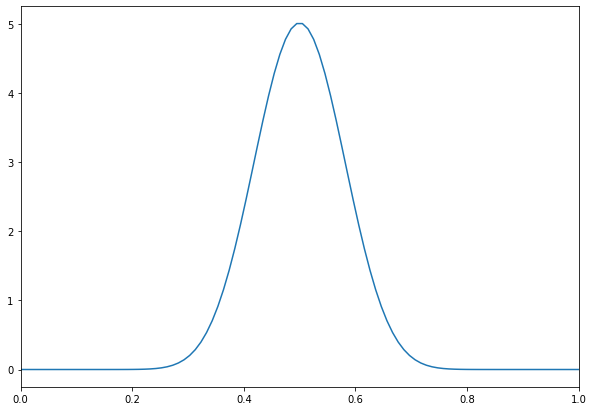

In [18]:
plt.figure(figsize=(10,7))
plt.xlim(0.0, 1)
alpha = 20
beta = 20
x = np.linspace(scipy.stats.beta.ppf(0.00, alpha, beta),scipy.stats.beta.ppf(1, alpha, beta), 100)
plt.plot(x, scipy.stats.beta.pdf(x, alpha, beta), 'r-', color='C0')
# alpha = 8
# beta = 70
# x = np.linspace(scipy.stats.beta.ppf(0.00, alpha, beta),scipy.stats.beta.ppf(1, alpha, beta), 100)
# plt.plot(x, scipy.stats.beta.pdf(x, alpha, beta), 'r-', color='C1')


# alpha = 42
# beta = 17
# x = np.linspace(scipy.stats.beta.ppf(0.00, alpha, beta),scipy.stats.beta.ppf(1, alpha, beta), 100)
# plt.plot(x, scipy.stats.beta.pdf(x, alpha, beta), 'r-', color='C2')





 ### 5. Thompson Sampling:
 
The Thompson Sampling solver implements probability matching.

For Bernoulli bandit, Q(a) follows a Beta distribution

By default, $\alpha$ and $\beta$ are set to 1 (50% reward probability).<br>
We can set initial $\alpha$ and $\beta$ based on our prior knowledge of reward probability.<br>

After pulling an arm i, the $\alpha$ and $\beta$ for i is updated.

In [19]:
class ThomsonSampling(Solver):
    def __init__(self, bandit, init_alpha=1, init_beta=1):
        """
        init_alpha (int): initial value of alpha in Beta(alpha, beta).
        init_beta (int): initial value of beta in Beta(alpha, beta).
        """
        super(ThomsonSampling, self).__init__(bandit)
        self._alphas = [init_alpha]*self.bandit.n
        self._betas = [init_beta]*self.bandit.n
        self.name = "Thomson Sampling"
        
    @property
    def estimated_thetas(self):
        return [self._alphas[i]/(self._alphas[i] + self._betas[i]) for i in range(self.bandit.n)]
    
    def run_one_step(self):
        # Get sample for each arm from beta distribution 
        samples = [np.random.beta(self._alphas[i], self._betas[i]) for i in range(self.bandit.n)]
        
        # Select best arm and get reward by pulling it
        arm = max(range(self.bandit.n), key=lambda x: samples[x]) # Get arm with highest sample value
        reward = self.bandit.pull_arm(arm)
        
        # Update alpha and beta for arm
        self._alphas[arm] += reward # Increment alpha by 1 if reward received
        self._betas[arm] += (1 - reward) # Increment beta by 1 if no reward received
        
        return arm

Now let's test the Thomson Sampling solver

In [20]:
thomson_solver = ThomsonSampling(bandit)
run_solver(thomson_solver)

Solver: Thomson Sampling
Cumulative regret (mean): 2.8350000000000217; Cumulative regret (std): 12.059654845807248
Actions per arm: [4.8, 18.75, 976.45]


## Compare the solvers

We now compare the solvers by running the experiment and printing the mean cumulative regret and standard deviation.

Solver: Random
Cumulative regret (mean): 99.39500000000012; Cumulative regret (std): 2.9635240845992734
Actions per arm: [328.1, 337.75, 334.15]
Solver: Greedy
Cumulative regret (mean): 99.99999999999861; Cumulative regret (std): 1.4210854715202004e-14
Actions per arm: [0.0, 1000.0, 0.0]
Solver: EpsilonGreedy
Cumulative regret (mean): 10.364999999999991; Cumulative regret (std): 1.320331397793747
Actions per arm: [34.45, 34.75, 930.8]
Solver: UCB1
Cumulative regret (mean): 8.805000000000003; Cumulative regret (std): 9.736913011832884
Actions per arm: [17.8, 52.45, 929.75]
Solver: Thomson Sampling
Cumulative regret (mean): 3.105000000000004; Cumulative regret (std): 6.438281991339012
Actions per arm: [3.15, 24.75, 972.1]


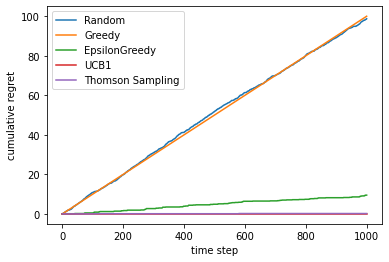

In [58]:
random_solver = Random(bandit)
greedy_solver = Greedy(bandit, random.choice(range(bandit.n)))
epsilon_greedy_solver = EpsilonGreedy(bandit, 0.1)
ucb_solver = UCB1(bandit)
thomson_solver = ThomsonSampling(bandit)
for solver in [random_solver, greedy_solver, epsilon_greedy_solver, ucb_solver, thomson_solver]:
    run_solver(solver)
    plt.plot(solver.regrets, label = solver.name)
    
plt.legend()
plt.xlabel('time step')
plt.ylabel('cumulative regret')
plt.show()

## In-class task 1: 
- Modify the bandit instance (add more arms, change $\theta$s).
- Change the target arm for Greedy.
- Change $\epsilon$ for $\epsilon$-Greedy.
- Specify strong prior for Thompson Sampling ( $\alpha$ and $\beta$ ).

Observe and discuss how the results vary.

## In-class task 2:
- Discuss how you could improve $\epsilon$-greedy with some small changes